In [33]:
# Imports
import json
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [34]:
# Constants
NSHARDS = 10
MODELS = ['MLP', 'GCN', 'HGCN']

In [44]:
def df_gen(RESULTS_DIR, NSHARDS):  
  dfs = []
  for shard_idx in range(NSHARDS):
    filename = 'results.ndjson-%s-of-%s' % (str(shard_idx).zfill(5), str(NSHARDS).zfill(5))
    print(filename)

    with open(f'{RESULTS_DIR}/{filename}', 'r') as f:
      lines = f.readlines()
      records = map(json.loads, lines)
      dfs.append(pd.DataFrame.from_records(records))

  # Construct df and remove nans
  results_df = pd.concat(dfs)
  results_df.drop(['marginal_param', 'fixed_params'], axis=1, inplace=True)
  # results_df.dropna(axis=0, inplace=True)
  del dfs
  return results_df

In [62]:
def plot_gen(df, METRIC):
	plt.scatter(df["MLP__" + METRIC], df["GCN__" + METRIC], s=5)
	plt.plot([0, 1], [0, 1], color='red', linestyle='--')
	plt.title(f'Performance comparison between GCN and MLP')
	plt.xlabel(f'{"GCN__" + METRIC}')
	plt.ylabel(f'{"MLP__" + METRIC}')
	plt.legend(fontsize='small')
	plt.tight_layout()
	plt.show()
	
	cluster_sizes = df['num_clusters'].unique()
	fig, axes = plt.subplots(2, 4, figsize=(12, 6))
	axes = axes.flatten()
	for cluster_size in np.sort(cluster_sizes):
		axes_index = cluster_size - cluster_sizes.min()
		df_2_clusters = df[df['num_clusters'] == cluster_size]
		MLP_better = df_2_clusters["MLP__" + METRIC] > df_2_clusters["GCN__" + METRIC]+.05
		GCN_better = df_2_clusters["GCN__" + METRIC] > df_2_clusters["MLP__" + METRIC]+.05
		total_samples = len(MLP_better)

		ax = axes[axes_index]
		ax.scatter(df_2_clusters["GCN__" + METRIC][MLP_better],
				df_2_clusters["MLP__" + METRIC][MLP_better], color = 'orange', s = 5)
		ax.scatter(df_2_clusters["GCN__" + METRIC][GCN_better],
				df_2_clusters["MLP__" + METRIC][GCN_better], color = 'green', s = 5)
		ax.scatter(df_2_clusters["GCN__" + METRIC][~(MLP_better | GCN_better)],
				df_2_clusters["MLP__" + METRIC][~(MLP_better | GCN_better)], s = 5)
		ax.plot([0, 1], [0, 1], color='red', linestyle='--')
		ax.scatter([], [], label=f"MLP better: {sum(MLP_better)}", color = 'orange')
		ax.scatter([], [], label=f"GCN better: {sum(GCN_better)}", color = 'green')
		ax.set_title(f'Number of classes: {cluster_size}')
		ax.set_xlabel(f'{"GCN__" + METRIC}')
		ax.set_ylabel(f'{"MLP__" + METRIC}')
		ax.legend(fontsize='small')

	# Hide unused subplots if cluster_sizes < 8
	for i in range(len(cluster_sizes), len(axes)):
		axes[i].axis('off')

	plt.suptitle("Performance comparison between GCN and MLP as number of classes increases")
	plt.tight_layout()
	plt.show()

	cluster_sizes = df['num_clusters'].unique()
	_, axes = plt.subplots(2, 4, figsize=(12, 6))
	axes = axes.flatten()
	for cluster_size in np.sort(cluster_sizes):
		axes_index = cluster_size - cluster_sizes.min()
		df_2_clusters = df[df['num_clusters'] == cluster_size]
		small_mask = df_2_clusters['nvertex'] < 2000
		mid_mask = (df_2_clusters['nvertex'] >= 2000) & (df_2_clusters['nvertex'] < 3000)
		large_mask = df_2_clusters['nvertex'] >= 3000
		ax = axes[axes_index]
		ax.scatter(df_2_clusters["MLP__" + METRIC][small_mask], df_2_clusters["GCN__" + METRIC][small_mask], s=10, color = 'green', label = '1000-2000')
		ax.scatter(df_2_clusters["MLP__" + METRIC][mid_mask], df_2_clusters["GCN__" + METRIC][mid_mask], s=10, color = 'orange', label = '2000-3000')    
		ax.scatter(df_2_clusters["MLP__" + METRIC][large_mask], df_2_clusters["GCN__" + METRIC][large_mask], s=10, color = 'red', label = '3000-4000')
		ax.set_title(f'Number of classes: {cluster_size}')
		ax.set_xlabel(f'{"MLP__" + METRIC}')
		ax.set_ylabel(f'{"GCN__" + METRIC}')
		ax.legend(fontsize='small')

	# Hide unused subplots if cluster_sizes < 8
	for i in range(len(cluster_sizes), len(axes)):
		axes[i].axis('off')

	plt.suptitle("Performance comparison between GCN and MLP based on graph size, stratified across number of classes")
	plt.tight_layout()
	plt.show()


	models = ['MLP', 'GCN', 'HGCN']

	plt.figure(figsize=(10, 6))

	for model in models:
		grouped = df.groupby('num_clusters')[f'{model}__test_accuracy']
		means = grouped.mean()
		stds = grouped.std()

		plt.errorbar(
			means.index, means.values, yerr=stds.values, fmt='o-', capsize=5, label=model
		)

	# Add random guessing baseline
	cluster_sizes = sorted(df['num_clusters'].unique())
	random_guess = [1 / c for c in cluster_sizes]
	plt.plot(cluster_sizes, random_guess, 'k--', label='Random Guessing')

	plt.xlabel('Number of Clusters')
	plt.ylabel('Accuracy')
	plt.title('Model Accuracy vs. Number of Clusters (mean ± std)')
	plt.grid(True)
	plt.legend()
	plt.tight_layout()
	plt.show()

In [ ]:
RESULTS_DIR_random_gs = '../../graph_gen/snellius_gen/random_gs/random_gs'
results_df_random_gs = df_gen(RESULTS_DIR_random_gs, NSHARDS)

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


In [52]:
smaller_graphs_df = df_gen("../../graph_gen/snellius_gen/smaller_graphs/smaller_graphs/", NSHARDS)

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_18404/3165775925.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize='small')


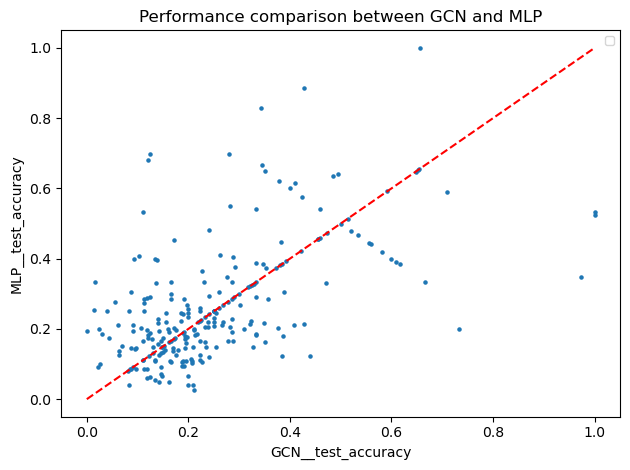

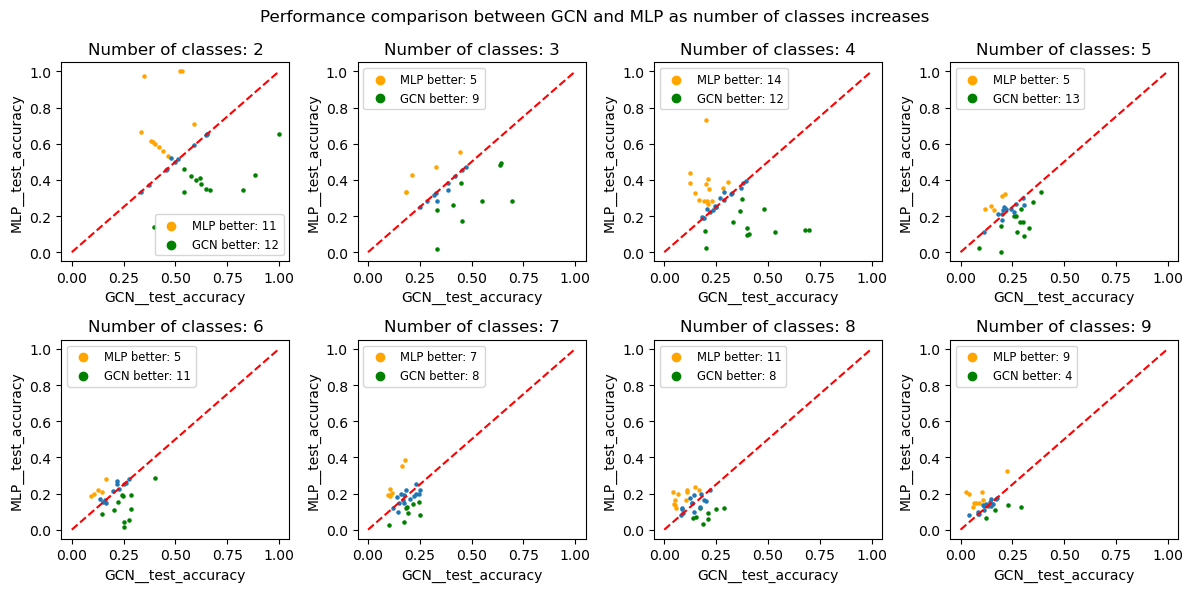

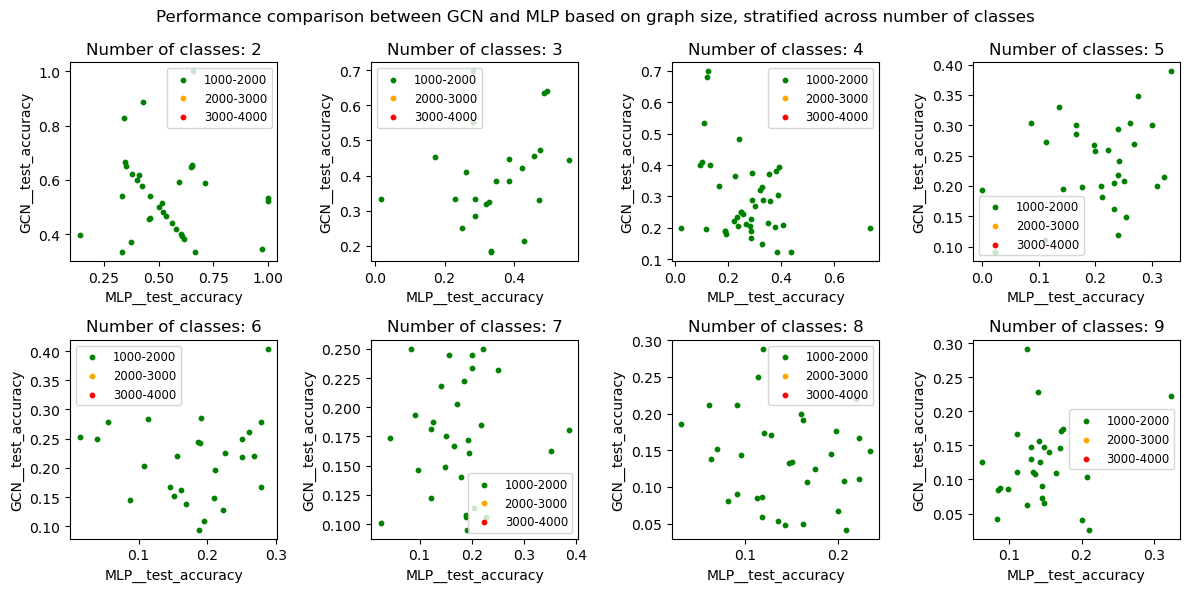

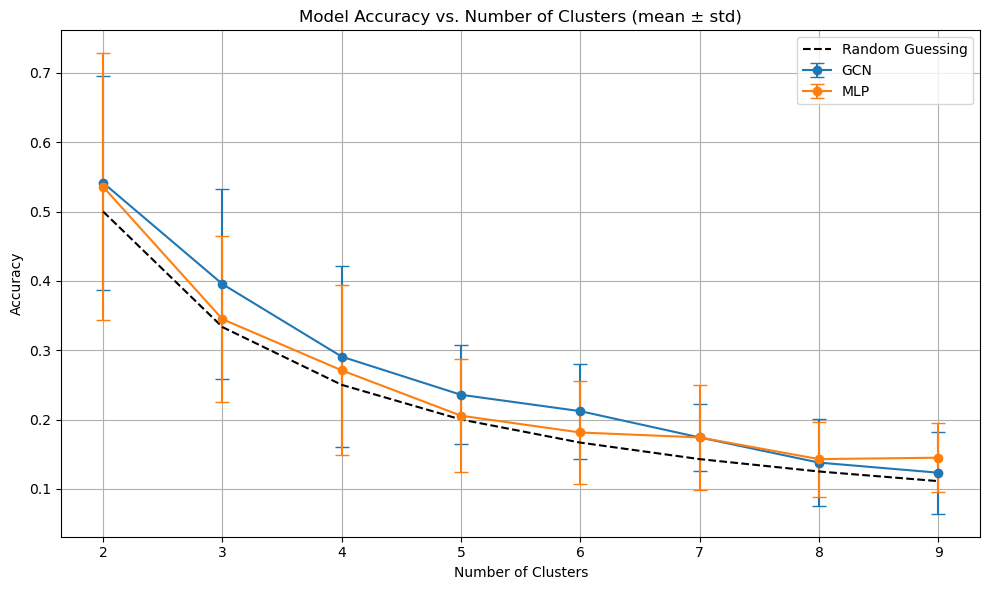

In [63]:
plot_gen(smaller_graphs_df, "test_accuracy")

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_18404/3165775925.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize='small')


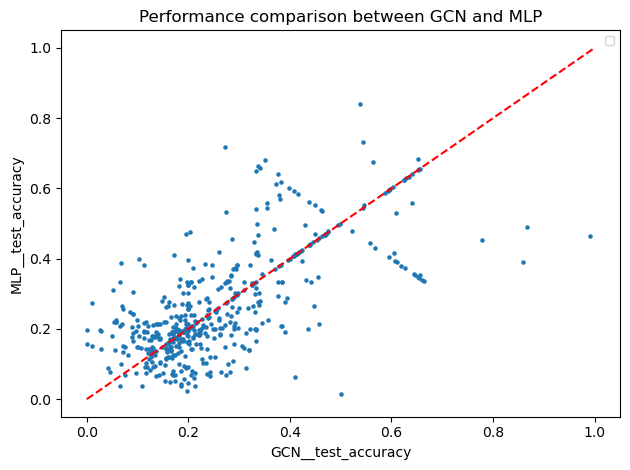

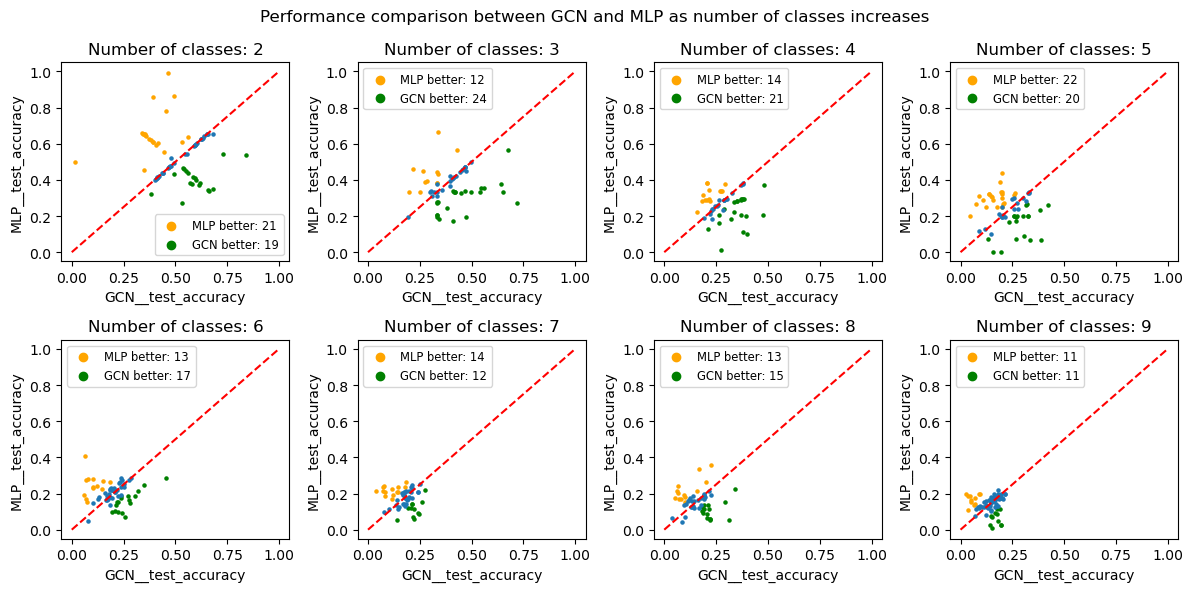

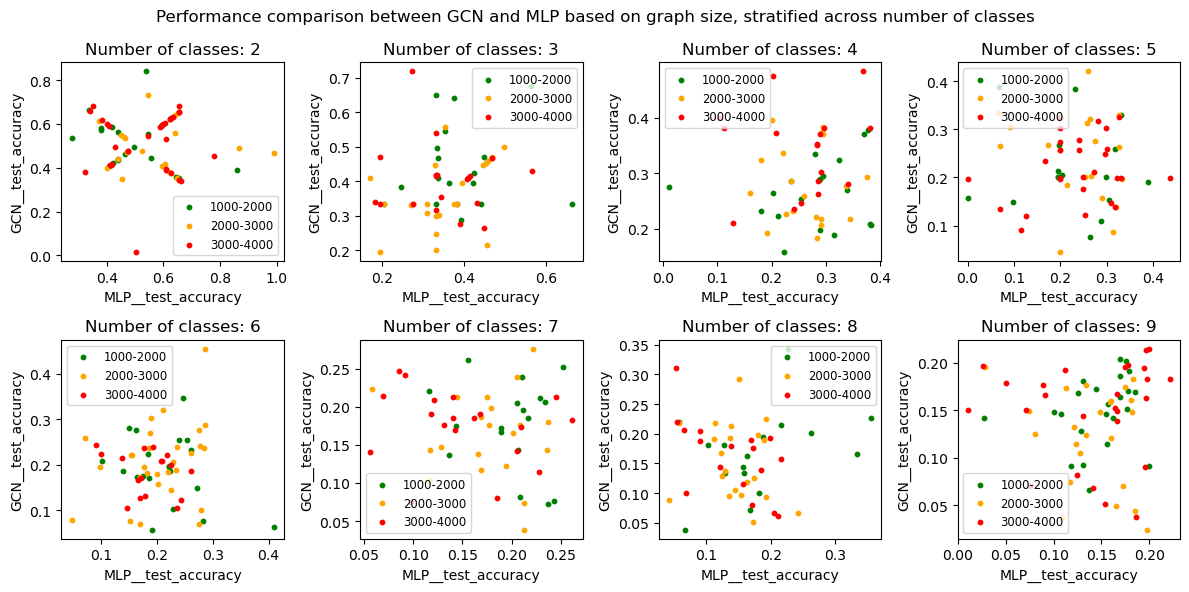

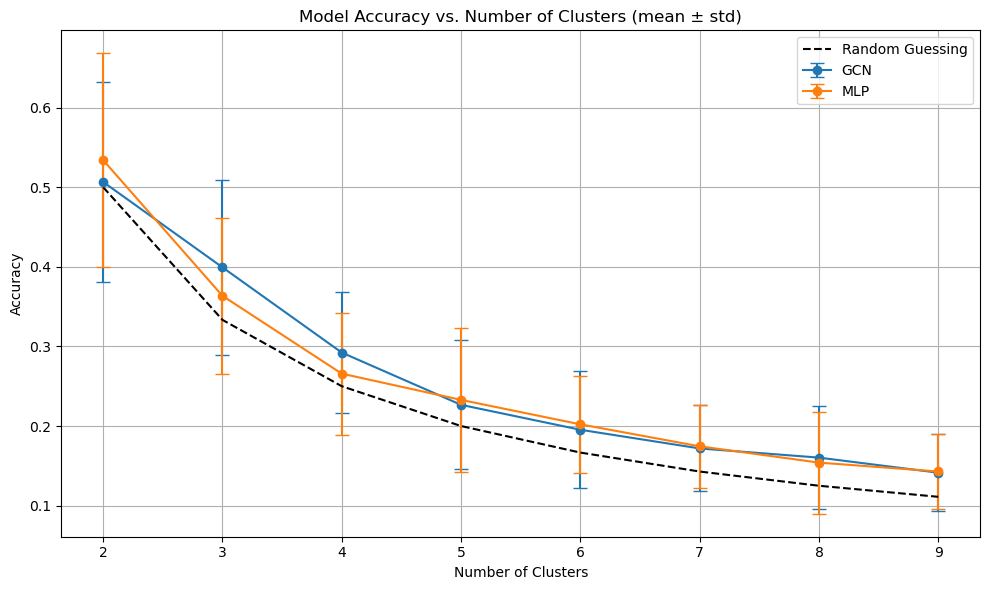

In [65]:
main_snellius_gen_link = "../../graph_gen/snellius_gen/nodeclassification/sbm/"
main_snellius_df = df_gen(main_snellius_gen_link, NSHARDS)
plot_gen(main_snellius_df, "test_accuracy")

## Varied feature dim investigations

In [62]:
RESULTS_DIR = '../../graph_gen/snellius_gen/vary_dim/'
two_df = df_gen(RESULTS_DIR= RESULTS_DIR + '2', NSHARDS = NSHARDS)
eight_df = df_gen(RESULTS_DIR= RESULTS_DIR + '8', NSHARDS = NSHARDS)
sixteen_df = df_gen(RESULTS_DIR= RESULTS_DIR + '16', NSHARDS = NSHARDS)


results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def combine_feature_dfs(df_list, feature_dims):
    """
    Given a list of DataFrames and corresponding feature_dim values,
    add a 'feature_dim' column to each and concatenate.
    """
    for df, dim in zip(df_list, feature_dims):
        df['feature_dim'] = dim
    return pd.concat(df_list, ignore_index=True)


def boxplot_metric_by_feature_dim(combined_df, models, metric, figsize=(8, 6)):
    """
    Create a boxplot of <model>__<metric> grouped by feature_dim, 
    for each model in `models`.
    
    Args:
        combined_df: DataFrame containing all feature_dim batches plus results.
        models: list of model prefixes, e.g. ['GCN', 'MLP', 'HGCN']
        metric: the performance metric suffix, e.g. 'test_accuracy'
        figsize: figure size tuple
    """
    colnames = [f"{m}__{metric}" for m in models]
    plt.figure(figsize=figsize)
    combined_df.boxplot(
        column=colnames,
        by='feature_dim',
        grid=True,
        patch_artist=False,
        boxprops=dict(color='orange'),
        medianprops=dict(color='red')
    )
    plt.suptitle('') 
    plt.title('')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.xlabel('Feature Dimension')
    plt.show()


def scatter_model_vs_model(combined_df, model_x, model_y, metric, cmap='viridis', figsize=(6, 6)):
    """
    Scatter plot of model_x vs model_y on <metric>, colored by feature_dim.
    
    Args:
        combined_df: the combined DataFrame.
        model_x: prefix string for X model, e.g. 'GCN'
        model_y: prefix string for Y model, e.g. 'HGCN'
        metric: performance metric suffix, e.g. 'test_accuracy'
        cmap: colormap for feature_dim
        figsize: size of figure
    """
    xcol = f"{model_x}__{metric}"
    ycol = f"{model_y}__{metric}"
    plt.figure(figsize=figsize)
    scatter = plt.scatter(
        combined_df[xcol],
        combined_df[ycol],
        c=combined_df['feature_dim'],
        cmap=cmap,
        alpha=0.7,
        edgecolors='w',
        s=60
    )
    plt.plot([combined_df[xcol].min(), combined_df[xcol].max()], 
             [combined_df[xcol].min(), combined_df[xcol].max()], 
             'r--', linewidth=1)
    cbar = plt.colorbar(scatter)
    cbar.set_label('feature_dim')
    plt.xlabel(f"{model_x} {metric.replace('_', ' ').title()}")
    plt.ylabel(f"{model_y} {metric.replace('_', ' ').title()}")
    plt.title(f"{model_x} vs {model_y} ({metric.replace('_', ' ').title()})")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def scatter_metric_vs_edge_density(combined_df, models, metric, figsize=(8, 6)):
    """
    Scatter plot of metric vs edge_density for each model in `models`.
    
    Args:
        combined_df: the combined DataFrame
        models: list of model prefixes, e.g. ['GCN', 'MLP', 'HGCN']
        metric: performance metric suffix, e.g. 'test_accuracy'
        figsize: size of figure
    """
    plt.figure(figsize=figsize)
    colors = ['goldenrod', 'teal', 'crimson', 'purple', 'navy']  # extend if needed
    for model, color in zip(models, colors):
        colname = f"{model}__{metric}"
        plt.scatter(
            combined_df['edge_density'],
            combined_df[colname],
            label=model,
            alpha=0.5,
            s=40,
            color=color
        )
    plt.xlabel('Edge Density')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f"{metric.replace('_', ' ').title()} vs Edge Density")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


def scatter_metric_vs_snr(combined_df, models, metric, snr_col='feature_angular_snr', figsize=(6, 4)):
    """
    For each model in `models`, scatter metric vs `snr_col` with a linear trend line.
    
    Args:
        combined_df: the combined DataFrame
        models: list of model prefixes, e.g. ['GCN', 'MLP', 'HGCN']
        metric: performance metric suffix, e.g. 'test_accuracy'
        snr_col: column name for feature SNR
        figsize: size of figure
    """
    for model in models:
        colname = f"{model}__{metric}"
        plt.figure(figsize=figsize)
        plt.scatter(
            combined_df[snr_col],
            combined_df[colname],
            alpha=0.6,
            s=40,
            color='goldenrod' if model=='GCN' else ('teal' if model=='MLP' else 'crimson')
        )
        # Fit linear trend
        m, b = np.polyfit(
            combined_df[snr_col],
            combined_df[colname],
            deg=1
        )
        xs = np.linspace(
            combined_df[snr_col].min(),
            combined_df[snr_col].max(),
            100
        )
        plt.plot(xs, m*xs + b, 'r--', linewidth=1.5)
        plt.xlabel(snr_col.replace('_', ' ').title())
        plt.ylabel(f"{model} {metric.replace('_', ' ').title()}")
        plt.title(f"{model} {metric.replace('_', ' ').title()} vs {snr_col.replace('_', ' ').title()}")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()


def boxplot_metric_vs_train_size(combined_df, model, metric, figsize=(8, 6)):
    """
    Boxplot of <model>__<metric> vs num_train_per_class, with hue=feature_dim.
    
    Args:
        combined_df: the combined DataFrame
        model: model prefix, e.g. 'HGCN'
        metric: performance metric suffix, e.g. 'test_accuracy'
        figsize: size of figure
    """
    colname = f"{model}__{metric}"
    plt.figure(figsize=figsize)
    sns.boxplot(
        x='num_train_per_class',
        y=colname,
        hue='feature_dim',
        data=combined_df,
        palette='magma'
    )
    plt.title(f"{model} {metric.replace('_', ' ').title()} vs Num Train per Class")
    plt.xlabel('Num Train per Class')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.legend(title='feature_dim')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_performance_vs_clusters(combined_df, model, metric):
    """
    Plots the average performance (given by `model__metric`) 
    versus number of ground‐truth clusters, for each feature_dim.
    Also includes a random‐guessing baseline (accuracy = 1/num_clusters).

    Args:
      combined_df: DataFrame containing at least these columns:
                   - 'feature_dim'
                   - 'num_clusters'
                   - f"{model}__{metric}"  (e.g. "HGCN__test_accuracy")
      model:       String prefix of the model, e.g. 'GCN', 'MLP', or 'HGCN'.
      metric:      String suffix of the performance metric, e.g. 'test_accuracy'.
    """
    colname = f"{model}__{metric}"
    # Drop any rows where the required columns are missing
    df = combined_df[['feature_dim', 'num_clusters', colname]].dropna()

    # Compute mean performance per (feature_dim, num_clusters)
    grouped = (
        df
        .groupby(['feature_dim', 'num_clusters'])[colname]
        .mean()
        .reset_index()
    )

    plt.figure(figsize=(8, 6))
    for dim in sorted(grouped['feature_dim'].unique()):
        sub = grouped[grouped['feature_dim'] == dim]
        plt.plot(
            sub['num_clusters'],
            sub[colname],
            marker='o',
            label=f"{model}, feat_dim={dim}"
        )

    # Random‐guessing baseline: accuracy = 1/num_clusters
    all_clusters = sorted(df['num_clusters'].unique())
    random_baseline = [1.0 / k for k in all_clusters]
    plt.plot(
        all_clusters,
        random_baseline,
        'k--',
        linewidth=1.5,
        label="Random Guessing"
    )

    plt.xlabel("Number of Clusters (num_clusters)")
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f"{model} {metric.replace('_', ' ').title()} vs Number of Clusters")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_models_vs_clusters_for_dim(combined_df, feature_dim, models, metric):
    """
    For a fixed feature_dim, plot each model's average performance (model__metric)
    versus number of ground‐truth clusters, all on the same axes, plus a random baseline.

    Args:
      combined_df: DataFrame containing ['feature_dim', 'num_clusters',
                    f"{model}__{metric}" for each model in `models`].
      feature_dim: Integer, the specific feature_dim to filter on (e.g. 2, 8, 16).
      models:      List of model prefixes, e.g. ['GCN', 'MLP', 'HGCN'].
      metric:      Performance metric suffix, e.g. 'test_accuracy' or 'test_f1_macro'.
    """
    # Filter to only rows with the specified feature_dim
    df = combined_df[combined_df['feature_dim'] == feature_dim]
    # Keep only num_clusters and each model__metric column
    keep_cols = ['num_clusters'] + [f"{m}__{metric}" for m in models]
    df = df[keep_cols].dropna()

    # Group by num_clusters and compute the mean for each model's metric
    grouped = df.groupby('num_clusters').mean().reset_index()

    plt.figure(figsize=(8, 6))
    for model in models:
        colname = f"{model}__{metric}"
        plt.plot(
            grouped['num_clusters'],
            grouped[colname],
            marker='o',
            label=model
        )

    # Add random‐guessing baseline: accuracy = 1/num_clusters
    num_clusters = grouped['num_clusters'].values
    random_baseline = 1.0 / num_clusters
    plt.plot(
        num_clusters,
        random_baseline,
        'k--',
        linewidth=1.5,
        label="Random Guessing"
    )

    plt.xlabel("Number of Clusters (num_clusters)")
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f"Models' {metric.replace('_', ' ').title()} vs Number of Clusters\n(feature_dim = {feature_dim})")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def boxplot_models_vs_clusters_for_dim(combined_df, feature_dim, models, metric, figsize=(8,6)):
    """
    For a fixed feature_dim, draw a grouped boxplot of each model’s performance (model__metric)
    versus num_clusters. No interpolation—just one box per model at each cluster size.

    Args:
      combined_df: DataFrame containing at least:
                   - 'feature_dim'
                   - 'num_clusters'
                   - f"{model}__{metric}" for each model in `models`
      feature_dim: Integer, the specific feature_dim to filter on (e.g. 2, 8, 16).
      models:      List of model prefixes, e.g. ['GCN', 'MLP', 'HGCN'].
      metric:      Performance metric suffix, e.g. 'test_accuracy' or 'test_f1_macro'.
      figsize:     Tuple for figure size (default (8,6)).
    """
    # Filter to the specified feature_dim
    df = combined_df[combined_df['feature_dim'] == feature_dim].copy()
    # Keep only num_clusters and each model__metric column, then drop NaNs
    keep_cols = ['num_clusters'] + [f"{m}__{metric}" for m in models]
    df = df[keep_cols].dropna()

    # Melt into long form: columns = ['num_clusters', 'model', 'performance']
    long_df = pd.melt(
        df,
        id_vars=['num_clusters'],
        value_vars=[f"{m}__{metric}" for m in models],
        var_name='model',
        value_name='performance'
    )
    # Strip off the "__<metric>" suffix so 'model' is just 'GCN', 'MLP', etc.
    long_df['model'] = long_df['model'].str.replace(f"__{metric}", "", regex=False)

    # Draw grouped boxplot
    plt.figure(figsize=figsize)
    sns.boxplot(
        x='num_clusters',
        y='performance',
        hue='model',
        data=long_df,
        palette='Set2'
    )

    plt.xlabel("Number of Clusters")
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f"Feature Dim = {feature_dim}: {metric.replace('_', ' ').title()} vs Num Clusters\n(Boxplot per model)")
    plt.legend(title='Model', loc='upper right', bbox_to_anchor=(1.25, 1))
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_all_models_regression_for_dim(combined_df, feature_dim, metric, x_col, ci=95):
    """
    For a fixed feature_dim, fit and plot a separate linear regression for each of three models
    (GCN, MLP, HGCN) vs x_col, all in the same axes, with confidence intervals.

    Args:
      combined_df: DataFrame containing at least these columns:
                   - 'feature_dim'
                   - x_col (e.g. 'avg_degree', 'feature_angular_snr', etc.)
                   - 'GCN__<metric>', 'MLP__<metric>', 'HGCN__<metric>'
      feature_dim: The single feature_dim value to filter (e.g. 2, 8, or 16).
      metric:      Metric suffix (e.g. 'test_accuracy' or 'test_f1_macro').
      x_col:       The independent variable column name (e.g. 'avg_degree').
      ci:          Confidence‐interval percentage for the regression lines.
    """
    # Build column names
    col_gcn  = f"GCN__{metric}"
    col_mlp  = f"MLP__{metric}"
    col_hgcn = f"HGCN__{metric}"

    # Filter to the specified feature_dim
    df = combined_df[combined_df['feature_dim'] == feature_dim].copy()
    df = df[[x_col, col_gcn, col_mlp, col_hgcn]].dropna()

    # Melt into long form: columns = [x_col, 'model', 'value']
    long_df = pd.melt(
        df,
        id_vars=[x_col],
        value_vars=[col_gcn, col_mlp, col_hgcn],
        var_name='model',
        value_name='performance'
    )
    # Simplify model names
    long_df['model'] = long_df['model'].str.replace(f"__{metric}", "")

    # Use seaborn's lmplot with hue='model' to overlay three regression lines
    sns.lmplot(
        data=long_df,
        x=x_col,
        y='performance',
        hue='model',
        ci=ci,
        markers=['o', 's', 'D'],
        palette='tab10',
        height=6,
        aspect=1.2
    )
    plt.xlabel(x_col.replace('_', ' ').title())
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(
        f"Regression of GCN / MLP / HGCN vs {x_col.replace('_', ' ').title()}\n"
        f"(feature_dim = {feature_dim})"
    )
    plt.tight_layout()
    plt.show()
    


<Figure size 800x600 with 0 Axes>

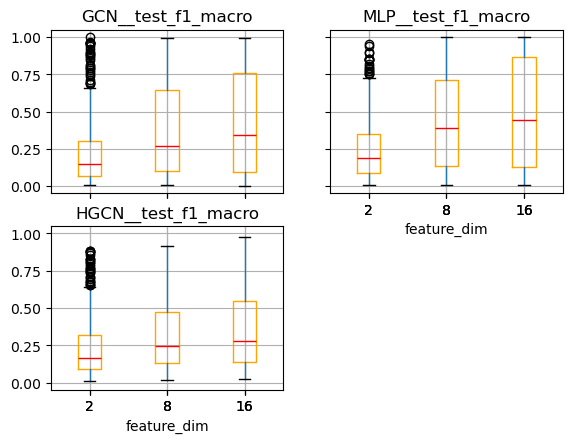

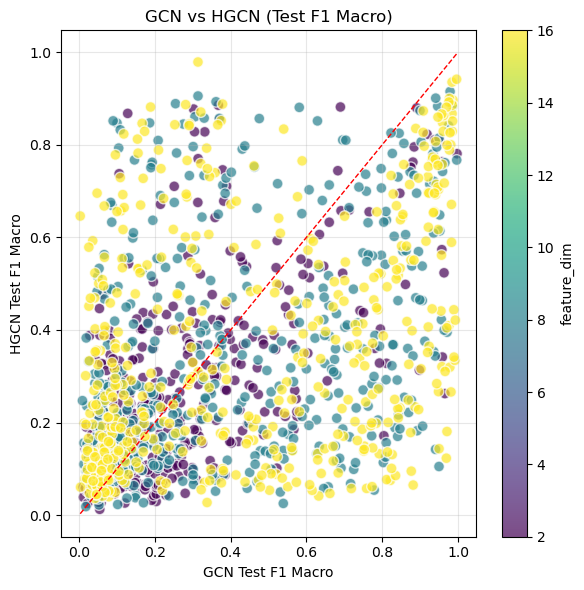

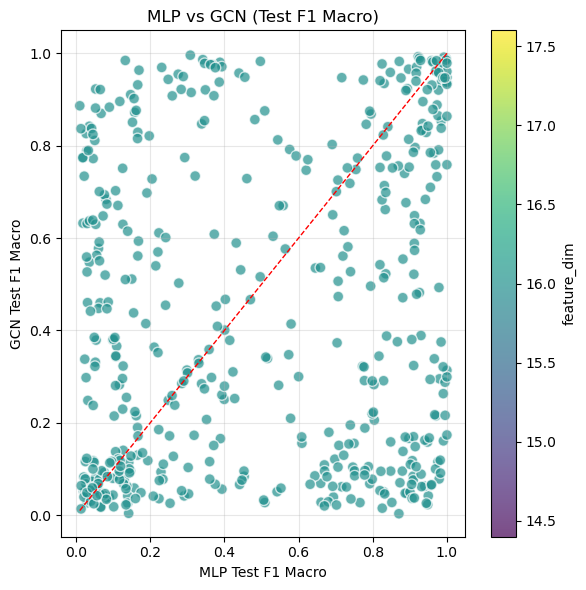

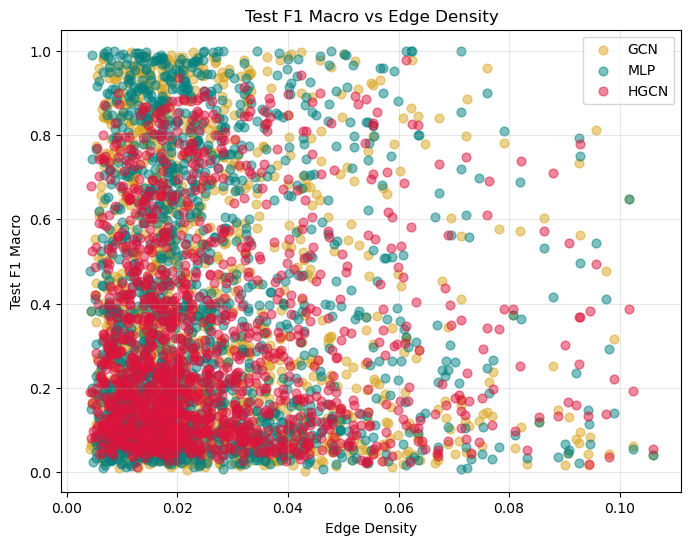

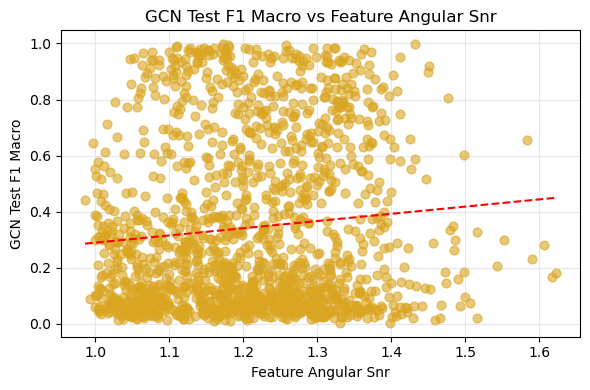

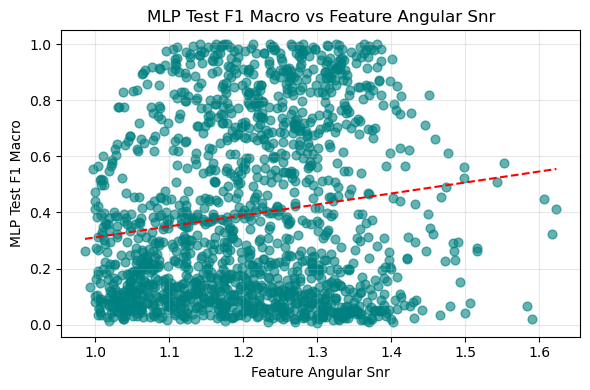

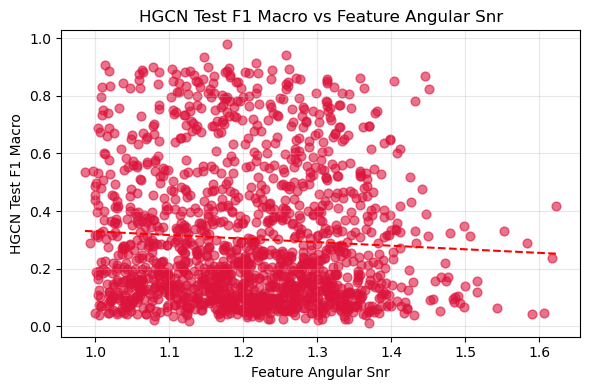

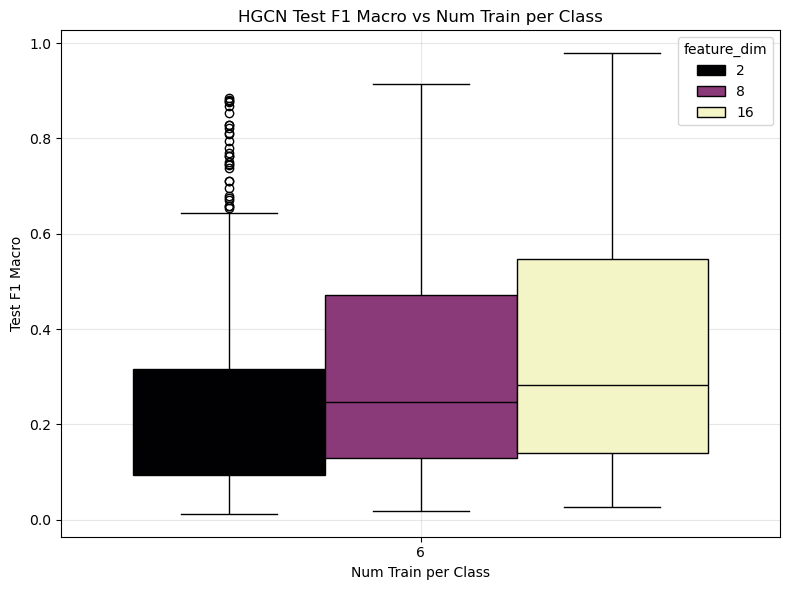

In [69]:
two_df['feature_dim']     = 2
eight_df['feature_dim']   = 8
sixteen_df['feature_dim'] = 16
combined_df = pd.concat([two_df, eight_df, sixteen_df], ignore_index=True)

# Step B: call any of the functions above. For example:
models = ['GCN', 'MLP', 'HGCN']
metric = 'test_f1_macro'

# 1) Boxplot by feature_dim
boxplot_metric_by_feature_dim(combined_df, models, metric)

# 2) Scatter GCN vs HGCN
scatter_model_vs_model(combined_df, 'GCN', 'HGCN', metric)
scatter_model_vs_model(sixteen_df, 'MLP', 'GCN', metric)

# 3) Accuracy vs edge_density for all three
scatter_metric_vs_edge_density(combined_df, models, metric)

# 4) Accuracy vs feature_angular_snr for each model
scatter_metric_vs_snr(combined_df, models, metric)

# 5) Boxplot of HGCN accuracy vs num_train_per_class, by feature_dim
boxplot_metric_vs_train_size(combined_df, 'HGCN', metric)

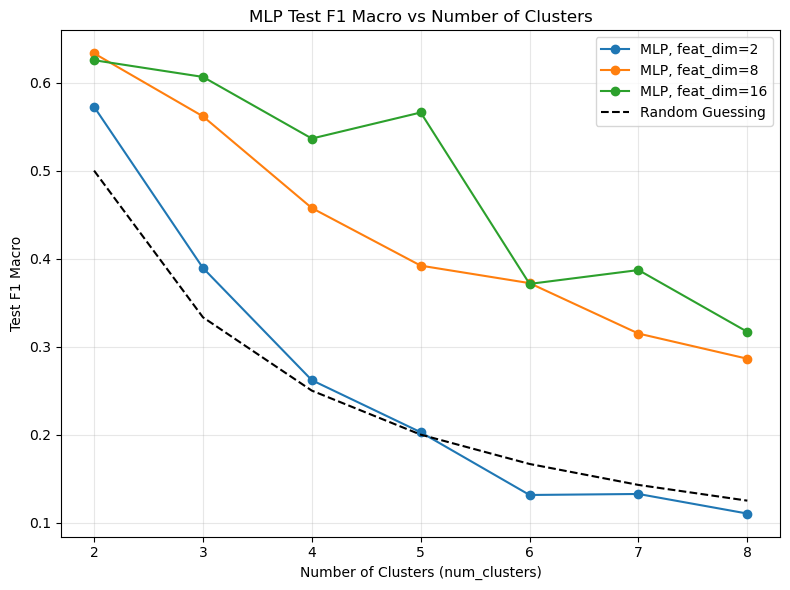

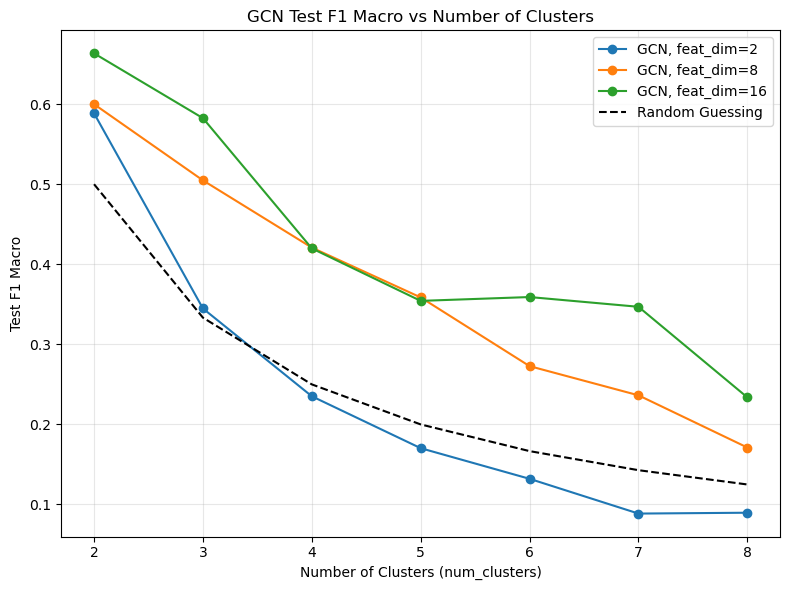

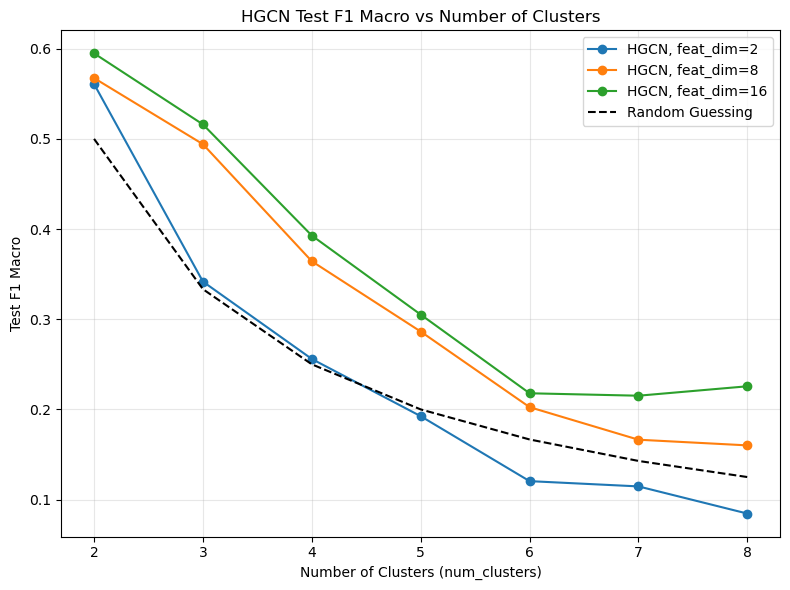

In [70]:
models = ['MLP', 'GCN', 'HGCN']
metric = 'test_f1_macro'
for model in models:
    plot_performance_vs_clusters(combined_df, model, metric)

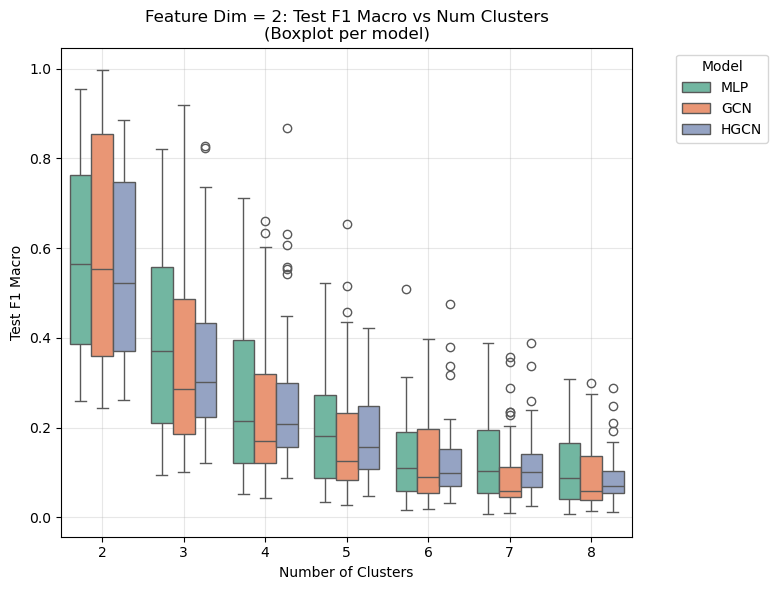

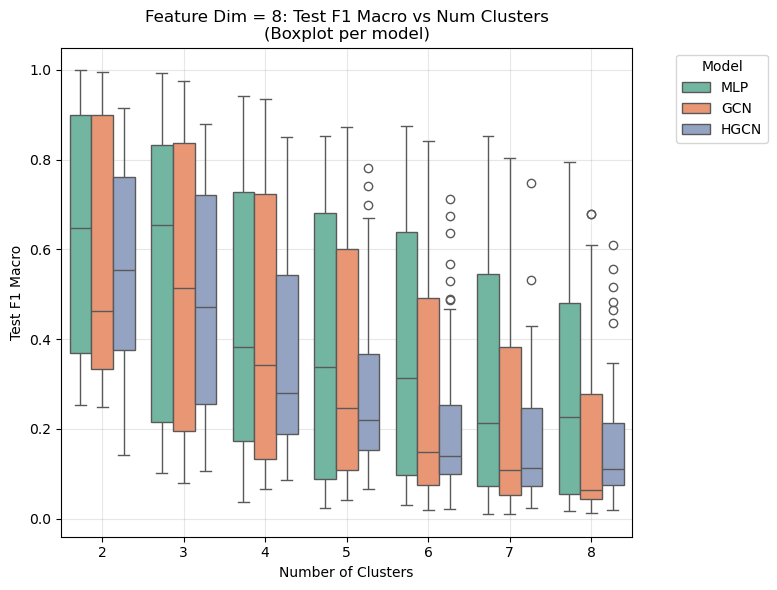

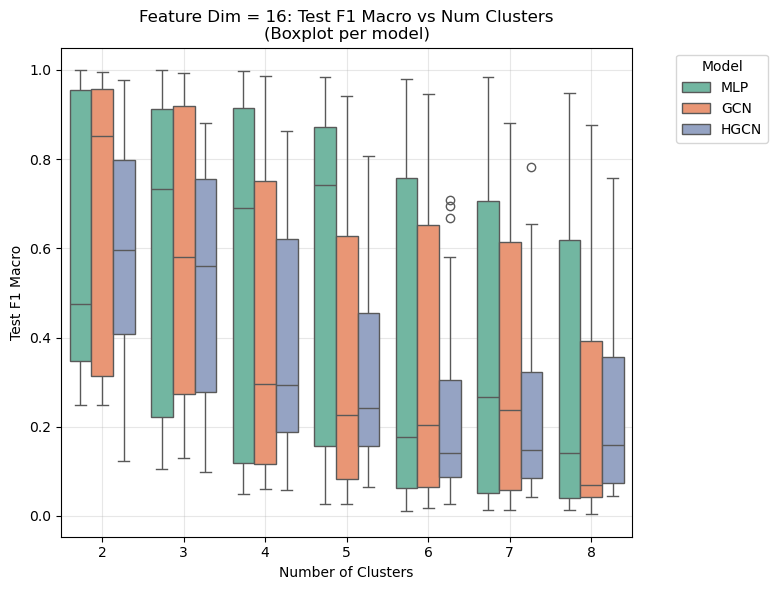

In [90]:
for dim in [2, 8, 16]:
    boxplot_models_vs_clusters_for_dim(combined_df, feature_dim=dim, models = models, metric = 'test_f1_macro')

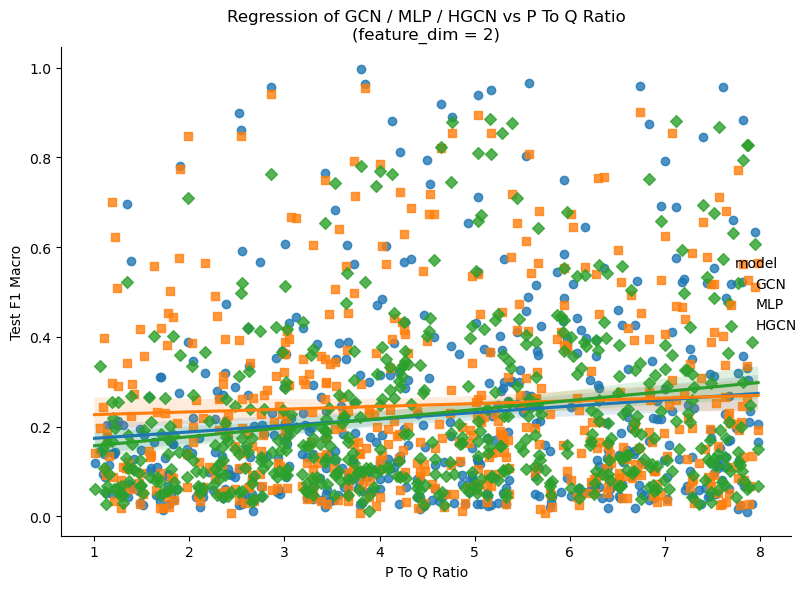

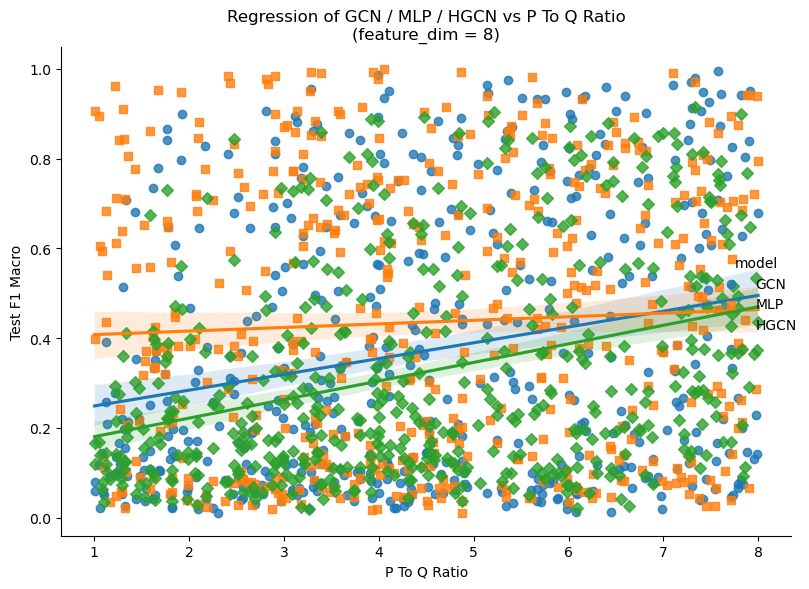

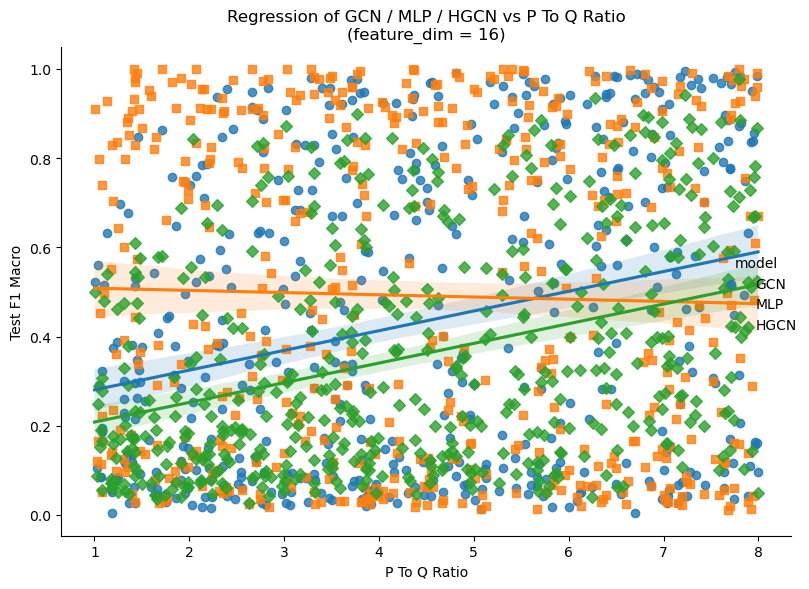

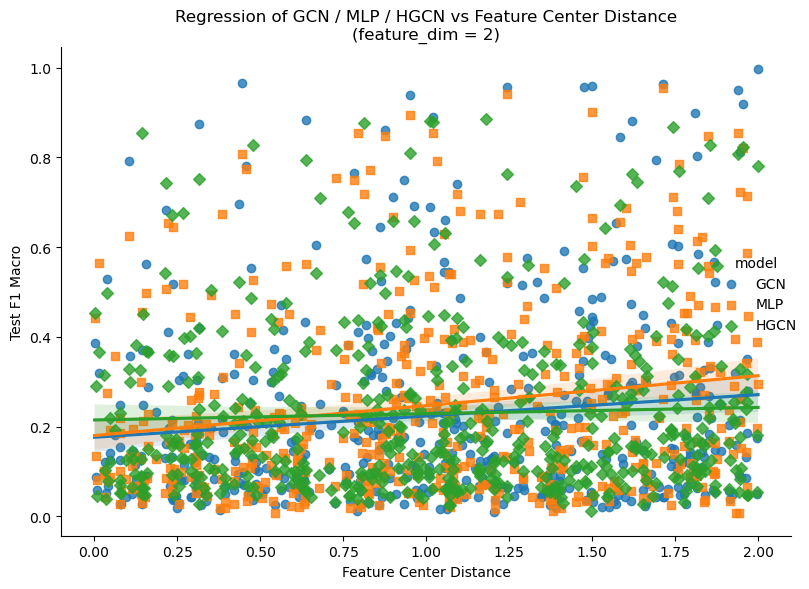

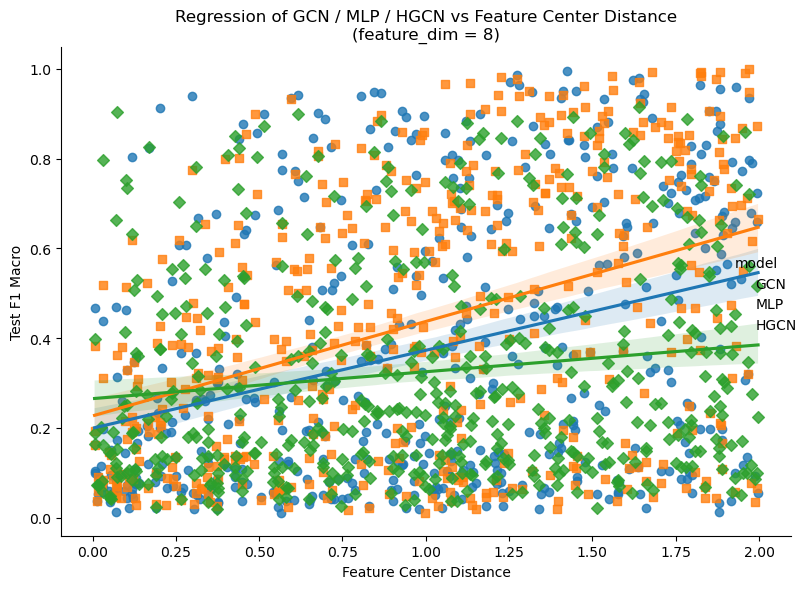

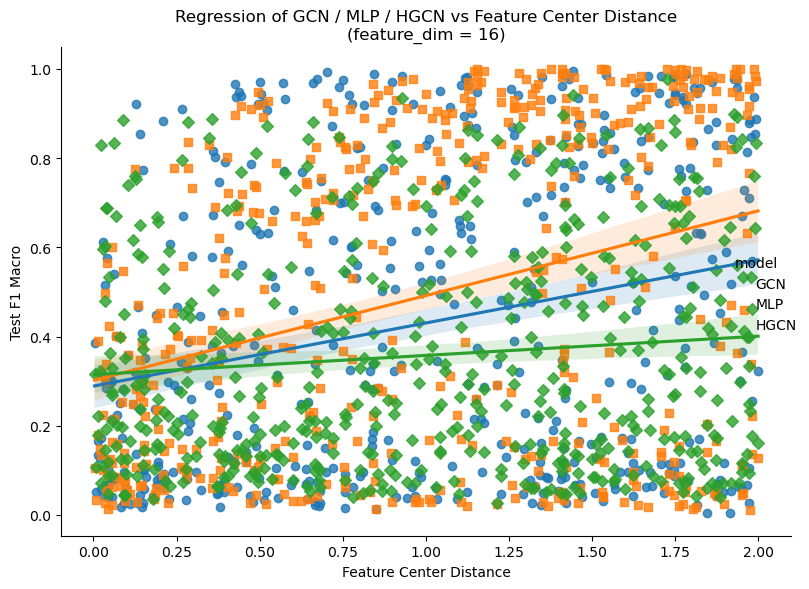

In [84]:
from itertools import product

for gen_param, dim in product(['p_to_q_ratio', 'feature_center_distance'], [2, 8, 16]):
    plot_all_models_regression_for_dim(combined_df=combined_df, feature_dim = dim, metric= metric, x_col = gen_param)